# 사전 작업

## 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import gc

In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', 400)

# 이상치 없는 데이터

## 데이터 로드

In [57]:
path = './data/'

In [86]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

In [87]:
# temp
train = train[train.target < 0]

In [104]:
train = train[train.outliers == 0]

In [26]:
train = train[train.outliers == 0]

## 제거할 피처

In [105]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## Parameter

In [106]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

## training model

In [107]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.19699	valid_1's rmse: 1.1941
[200]	training's rmse: 1.17496	valid_1's rmse: 1.18074
[300]	training's rmse: 1.16006	valid_1's rmse: 1.17446
[400]	training's rmse: 1.14834	valid_1's rmse: 1.17135
[500]	training's rmse: 1.13857	valid_1's rmse: 1.16979
[600]	training's rmse: 1.12985	valid_1's rmse: 1.16875
[700]	training's rmse: 1.12186	valid_1's rmse: 1.16801
[800]	training's rmse: 1.11458	valid_1's rmse: 1.16778
[900]	training's rmse: 1.10782	valid_1's rmse: 1.16751
[1000]	training's rmse: 1.10125	valid_1's rmse: 1.16721
[1100]	training's rmse: 1.09501	valid_1's rmse: 1.1671
[1200]	training's rmse: 1.08921	valid_1's rmse: 1.16703
[1300]	training's rmse: 1.08343	valid_1's rmse: 1.16688
[1400]	training's rmse: 1.07776	valid_1's rmse: 1.16682
[1500]	training's rmse: 1.07237	valid_1's rmse: 1.16684
[1600]	training's rmse: 1.06698	valid_1's rmse: 1.16684
Early stopping, best iteration is:
[1445]	t

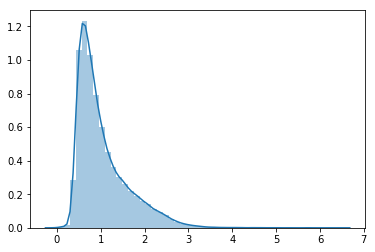

In [84]:
sns.distplot(predictions_lgb)

In [85]:
predictions_lgb[predictions_lgb > 4]

array([4.22151722, 4.27967981, 4.05134947, 4.06961571, 4.91665959,
       5.30348202, 6.2511952 , 4.09127727, 4.06930713, 4.47210227,
       5.70444138, 4.30440023, 4.12686245, 4.79993987, 4.38807065,
       4.16803079, 4.88080868, 4.71105015, 4.68283189, 4.35583158,
       5.29836645, 5.74309708, 4.02133085, 4.42520831, 4.18954932,
       4.20145177, 5.6915638 , 5.04569171, 4.44470573, 4.40042437,
       6.51440448, 4.04254987, 4.45790315, 4.24687057, 4.53854769,
       5.0202547 , 4.24784396, 4.15747875, 4.25557146, 4.11122674,
       4.0298778 , 4.62629335, 4.15028976, 4.01467996, 4.0120743 ,
       4.42560888, 4.49450004, 4.2487609 , 4.66364618, 5.75874413,
       5.89478446, 5.68730824, 4.6871668 , 4.87989926, 4.54355249,
       4.5768149 , 4.0401297 , 4.18355578, 4.84898438, 4.07463298,
       4.07567796, 4.27018324, 4.07026355, 4.20717674, 5.0237527 ,
       4.52676312, 4.53795924, 4.70101358, 4.0384599 , 4.66876828,
       4.76974613, 5.08751426, 4.94797528, 4.1970855 , 4.23118

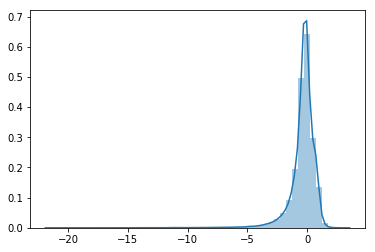

In [68]:
sns.distplot(predictions_lgb)

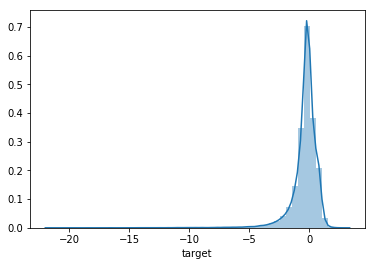

In [56]:
sns.distplot(best_submission.target)

In [51]:
sorted(predictions_lgb)

[-4.626029686886201,
 -4.273808350440785,
 -4.14525673519772,
 -4.062191827861109,
 -3.983177305433381,
 -3.961872852017277,
 -3.880058591387848,
 -3.8742803498057596,
 -3.8465536839965377,
 -3.788910789295521,
 -3.787920088541288,
 -3.78782803187701,
 -3.7773744438256243,
 -3.7691031137803455,
 -3.7560113710772605,
 -3.6907603591940026,
 -3.659581273377065,
 -3.643343959447833,
 -3.6432443143847597,
 -3.638568292203618,
 -3.638468610307538,
 -3.6363999499718833,
 -3.6105163327906284,
 -3.6050639074914477,
 -3.5974881838990838,
 -3.577385167068181,
 -3.5749788947604104,
 -3.569306060313229,
 -3.5636791212963734,
 -3.550803677866722,
 -3.549380378872507,
 -3.5418064407458214,
 -3.5362142893054167,
 -3.50758995956133,
 -3.5022215333197897,
 -3.4988354624308444,
 -3.46940654144212,
 -3.46462084105207,
 -3.4564772520600284,
 -3.4394477925616975,
 -3.436258008644364,
 -3.4101862312414735,
 -3.4094077468810218,
 -3.3998027481299067,
 -3.397828754252438,
 -3.3938214095109243,
 -3.389109905239

In [55]:
sorted(best_submission.target.values)

[-21.65253563012969,
 -20.355256276708133,
 -19.98393724826069,
 -19.887154061156767,
 -19.665530746684443,
 -19.5427254233778,
 -19.21003497638112,
 -18.538639434912024,
 -18.357497988689,
 -18.290457550944666,
 -17.59655489718289,
 -17.36954405356994,
 -17.233237715084492,
 -17.0938036898896,
 -16.787906747299573,
 -16.74461893786681,
 -16.58207637245503,
 -16.556172734759844,
 -16.549993064535442,
 -16.491985965435042,
 -16.468863803690994,
 -16.37997048419442,
 -16.281552012273544,
 -15.956881872031335,
 -15.80665848303277,
 -15.75110761862488,
 -15.632234374892388,
 -15.411246765983286,
 -15.359308237340839,
 -15.232148337094225,
 -15.158704632160829,
 -15.126366926126616,
 -15.034226912020207,
 -14.937595557913125,
 -14.880173106402571,
 -14.869863411458011,
 -14.84677291899732,
 -14.797746124009445,
 -14.75646383377482,
 -14.61629267909821,
 -14.606484244674801,
 -14.57134208800078,
 -14.550585569300349,
 -14.437201744190027,
 -14.416713162214538,
 -14.296526364412305,
 -14.2818

In [31]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions_lgb

# 이상치 예측 모델

## 데이터 로드

In [32]:
train = pd.read_csv(path + 'train_v2.csv')
test = pd.read_csv(path + 'test_v2.csv')

In [33]:
target = train['outliers']

## 제거할 피처

In [34]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## 파라미터

In [35]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [36]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(log_loss(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439502	valid_1's binary_logloss: 0.046651
[200]	training's binary_logloss: 0.043982	valid_1's binary_logloss: 0.0466416
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0438852	valid_1's binary_logloss: 0.0466866
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.043979	valid_1's binary_logloss: 0.0471535
[200]	training's binary_logloss: 0.0440188	valid_1's binary_logloss: 0.0471668
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0440208	valid_1's binary_logloss: 0.0470234
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0442937	valid_1's binary_logloss: 0.046197
[200]	training's binary_logloss: 0.0443698	valid_1's binary_logloss: 0.0462853
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0442569	valid_1's bi

In [37]:
outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
outlier_prob["target"] = predictions_lgb

# Combining

In [19]:
outlier_id = pd.DataFrame(outlier_prob.sort_values(by='target',ascending = False).head(25000)['card_id'])

In [52]:
best_submission = pd.read_csv(path + 'submission_best_score.csv')

In [21]:
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [22]:
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [108]:
model_without_outliers.to_csv("./data/combining_submission.csv", index=False)